# Data Science Challenge

(refer to README for the challenge description)

My first approach was to stick to the basics: TF-IDF + Naive Bayes. The results were no good, so I tried several flavors of SVM.

Why?

Naive Bayes is simple, fast and had some great results in the past for text classification. I try it first to have a baseline.

SVM seems to be one of the best in the present days, unless we go to Neural Networks, I guess, so it was my next step. The classification accuracy increased a lot.

I didn't reach accuracy over 90% as the pre-requisites, probably my data preparation is poor. I tried stemming, but the results didn't improved much. Maybe Latent Semantic Analysis to identify synonyms, but it seem too much right now.

As you asked for >90% accuracy in 2-4 hours, my feeling is that I'm missing something really obvious here. But...

Anyway... my next steps would be:

1. Talk to someone more experienced on that (in a real situation, of course).
2. Search a little more for another algorithm.
3. Experimenting with feature engineering, the algorithms don't make miracles, but playing with the features usually leads to big improvements. That's were I'm probably missing something, like separate Pros and Cons.
4. Spend a little more time doing Grid Search. It's slow, but requires only computer time, and also it can improve a lot some models.
5. Precision and Recall. I wouldn't finish this without calculate them. IMHO, they provide a good picture of the model performance. Accuracy can be misleading,

Also, I would create separate models for each language. The stemming in languages that have more verb flexion (latin languages mostly) can make a bigger difference.

Finally, I made a big mistake here, I tried to use the whole data set for all algorithms. It's fast for the MultinomialNB and SGDClassifier, but it was really slow with the other algorithms I tried (SVC, NuSVC, XGBoost). That made me spend a lot of time just waiting instead of play more with the features.

## Preparing

Fist run:

    pipenv install
    pipenv shell
    python -m ipykernel install --user --name=<env-name>
    jupyter notebook

Once the kernel is installed:

   pipenv run jupyter notebook

In [12]:
import pickle
import re
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, GridSearchCV
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.svm import LinearSVC

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Easier to compare results
pd.options.display.float_format = '{:.5f}'.format

from IPython.display import display

from langdetect import detect as langdetect
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/ronie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load data and check the format

In [4]:
raw = pd.read_pickle('data/labelled_dataset.pickle')
raw.head()

,text,labelmax
0,Pros - The people who work here are brilliant ...,customer
1,Pros Start-up vibes Fast growing company Tech-...,customer
2,"Pros The team is great, I love the ambition of...",collaboration
3,"Pros The company is constantly growing, and at...",adaptability
4,Pros Cool office. Friendly people. Good atmosp...,collaboration


In [5]:
raw.text[0]

"Pros - The people who work here are brilliant (intelligent, hard-working etc.) - Exciting career opportunities, plenty of room to grow! - Great company culture, social events etc. - Management really value everyone's opinion and are open to ideas - Ambitious company, always working to grow and improve - I feel like my work is really valued, and outstanding performance is always recognised by management Cons - Salary isn't great compared to other grad jobs, hopefully this will improve as the company grows - Occasionally have to work weekends, would much rather there was a separate weekend team - Communication could be better about changes in the company, future plans etc. Advice to Management - Keep listening to your employees - Don't become cold and corporate. Airsorted needs to keep the company spirit, even when it is a big global company."

In [6]:
raw.labelmax.value_counts()

customer         26981
collaboration    21067
result           18948
adaptability     17204
detail            4030
integrity         2815
null               535
Name: labelmax, dtype: int64

## Cleaning data

In [30]:
#raw['lang'] = raw.text.apply(langdetect) # Language Detection

# Create mixed class with the two worst classified ones
raw['proxy_class'] = raw.labelmax
is_proxy_class = ~raw.labelmax.isin(['integrity', 'detail'])
raw.proxy_class.where(is_proxy_class, 'integrity_detail', inplace=True)
raw[raw.proxy_class == 'integrity_detail'].head()

,text,labelmax,lang,proxy_class
10,"Pros Excellent Benefits, awesome work environm...",detail,en,integrity_detail
28,"Pros Lot of independence, good remuneration pa...",detail,en,integrity_detail
29,Pros Free lunch on Fridays and company functio...,detail,en,integrity_detail
69,"Pros Good work life balance, good pay and very...",integrity,en,integrity_detail
90,"Pros dynamic, talented team-some of the best p...",detail,en,integrity_detail


In [31]:
clean = raw[(raw.labelmax != 'null') & (raw.lang == 'en')] # Keep only english comments with classification

In [32]:
clean.head()

,text,labelmax,lang,proxy_class
0,Pros - The people who work here are brilliant ...,customer,en,customer
1,Pros Start-up vibes Fast growing company Tech-...,customer,en,customer
2,"Pros The team is great, I love the ambition of...",collaboration,en,collaboration
3,"Pros The company is constantly growing, and at...",adaptability,en,adaptability
4,Pros Cool office. Friendly people. Good atmosp...,collaboration,en,collaboration


In [9]:
from nltk.stem.snowball import EnglishStemmer

stemmer = EnglishStemmer()
analyzer = CountVectorizer().build_analyzer()

def process_words(doc):
    words = [stemmer.stem(w) for w in analyzer(doc)]
    return ['NUMBER' if word.isdigit() else word for word in words]

In [40]:
features_train, features_test, target_train, target_test = train_test_split(clean.text, clean.labelmax, test_size=0.1, stratify=clean.labelmax)

word_counter = TfidfVectorizer(stop_words='english',
                               analyzer=process_words,
                               ngram_range=(1, 3))
features = word_counter.fit_transform(features_train)
feature_names = word_counter.get_feature_names()
display(len(feature_names))

29810

In [ ]:
model = LinearSVC(class_weight={'detail': 3, 'integrity': 3}, penalty='l1', dual=False, C=0.25)

In [137]:
rfe = RFE(model, 5000, step=0.25)
rfe.fit(features, target_train)

RFE(estimator=LinearSVC(C=0.25, class_weight={'detail': 3, 'integrity': 3}, dual=False,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l1', random_state=None,
     tol=0.0001, verbose=0),
  n_features_to_select=5000, step=0.25, verbose=0)

In [138]:
print(len(np.array(feature_names)[rfe.support_]))

5000


In [139]:
model = LinearSVC(class_weight={'detail': 3, 'integrity': 3}, penalty='l1', dual=False, C=0.25)
model.fit(rfe.transform(features), target_train)

predicted_train = model.predict(rfe.transform(features))
predicted_test = model.predict(rfe.transform(word_counter.transform(features_test)))

labels = sorted(set(target_train))
cm_train = confusion_matrix(target_train, predicted_train, labels)
cm_test = confusion_matrix(target_test, predicted_test, labels)

display('Train Accuracy: {}'.format(accuracy_score(target_train, predicted_train)))
display('Test Accuracy: {}'.format(accuracy_score(target_test, predicted_test)))

'Train Accuracy: 0.9086136691098164'

'Test Accuracy: 0.887473221332732'

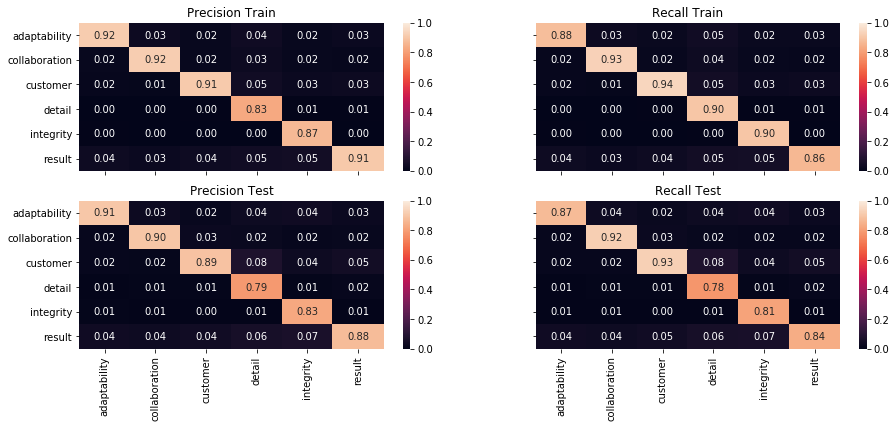

In [140]:
fig, charts = plt.subplots(2, 2, figsize=(15, 6), sharex=True, sharey=True)

charts[0, 0].set_title('Precision Train')
sns.heatmap(cm_train / cm_train.sum(axis=0),
            ax=charts[0, 0],
            annot=True,
            fmt='.2f',
            xticklabels=labels,
            yticklabels=labels,
            vmin=0, vmax=1)

charts[0, 1].set_title('Recall Train')
sns.heatmap(cm_train / cm_train.sum(axis=1),
            ax=charts[0, 1],
            annot=True,
            fmt='.2f',
            xticklabels=labels,
            yticklabels=labels,
            vmin=0, vmax=1)

charts[1, 0].set_title('Precision Test')
sns.heatmap(cm_test / cm_test.sum(axis=0),
            ax=charts[1, 0],
            annot=True,
            fmt='.2f',
            xticklabels=labels,
            yticklabels=labels,
            vmin=0, vmax=1)

charts[1, 1].set_title('Recall Test')
sns.heatmap(cm_test / cm_test.sum(axis=1),
            ax=charts[1, 1],
            annot=True,
            fmt='.2f',
            xticklabels=labels,
            yticklabels=labels,
            vmin=0, vmax=1)


## Helpers

This little functions help to test with different models.

In [96]:
from gensim.models.word2vec import Word2Vec
from nltk.tokenize import RegexpTokenizer
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

tokenizer = RegexpTokenizer(r'\w+')
sentences = [list(map(lambda x: x.lower(), tokenizer.tokenize(text))) for text in clean.text]
w2v_model = Word2Vec(sentences, size=200)

2018-05-06 17:25:21,838 : INFO : collecting all words and their counts
2018-05-06 17:25:21,839 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-05-06 17:25:21,957 : INFO : PROGRESS: at sentence #10000, processed 640595 words, keeping 16297 word types
2018-05-06 17:25:22,078 : INFO : PROGRESS: at sentence #20000, processed 1272682 words, keeping 21877 word types
2018-05-06 17:25:22,247 : INFO : PROGRESS: at sentence #30000, processed 2121160 words, keeping 27651 word types
2018-05-06 17:25:22,412 : INFO : PROGRESS: at sentence #40000, processed 2960925 words, keeping 32020 word types
2018-05-06 17:25:22,565 : INFO : PROGRESS: at sentence #50000, processed 3703521 words, keeping 35859 word types
2018-05-06 17:25:22,728 : INFO : PROGRESS: at sentence #60000, processed 4525228 words, keeping 39840 word types
2018-05-06 17:25:22,844 : INFO : PROGRESS: at sentence #70000, processed 5122256 words, keeping 42143 word types
2018-05-06 17:25:23,005 : INFO : PROGRES

In [117]:
w2v = dict(zip(w2v_model.wv.index2word, w2v_model.wv.vectors))
w2v

{'to': array([-0.64220005, -1.0413845 , -0.44116792, -0.9219972 , -0.3362537 ,
        -0.6873523 ,  0.48383027, -2.4243655 ,  0.9338503 ,  0.2721937 ,
        -0.12057874, -1.2954686 , -0.5091929 ,  0.5588085 ,  0.61393523,
        -0.45094275, -1.2081062 , -1.0247352 , -1.1905748 , -1.1596457 ,
         0.6696739 , -0.6463204 ,  0.24017884, -0.31767586,  0.41521385,
        -0.25767428, -0.98723114,  0.97309583, -0.1916647 ,  0.4330978 ,
        -0.01922037,  0.5890137 , -0.43333626, -1.6076561 , -0.2932795 ,
         0.5168416 , -1.3682393 ,  0.52594584, -1.7545774 , -0.82109535,
         0.10017733,  1.3762672 ,  0.7399508 , -0.1784148 , -0.7878262 ,
        -0.9393912 ,  2.1849964 , -0.91905046,  0.15670332, -0.48861778,
        -0.8135527 , -1.1101966 , -1.676632  ,  0.8943276 ,  0.5088523 ,
        -0.36342168, -1.3165903 ,  0.65774953,  0.04256732, -0.1366273 ,
         0.24261864,  1.1680042 , -1.0142752 ,  0.5797556 ,  1.6114904 ,
        -0.7306163 ,  1.4698285 ,  2.557421  

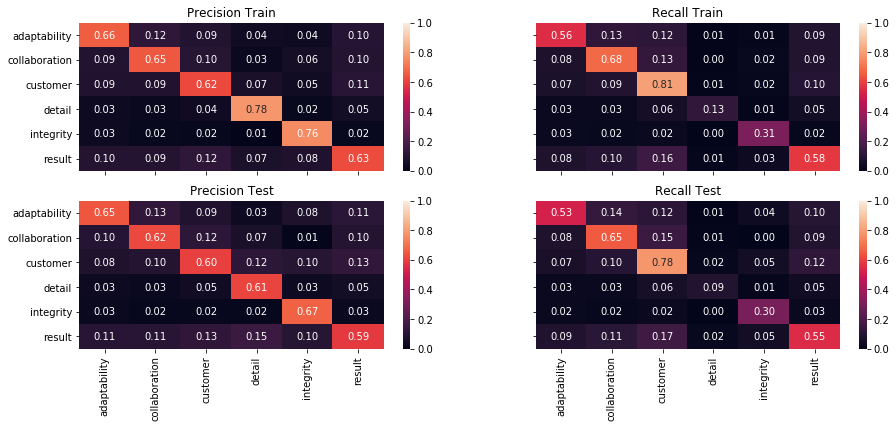

In [83]:
fig, charts = plt.subplots(2, 2, figsize=(15, 6), sharex=True, sharey=True)

charts[0, 0].set_title('Precision Train')
sns.heatmap(cm_train / cm_train.sum(axis=0),
            ax=charts[0, 0],
            annot=True,
            fmt='.2f',
            xticklabels=labels,
            yticklabels=labels,
            vmin=0, vmax=1)

charts[0, 1].set_title('Recall Train')
sns.heatmap(cm_train / cm_train.sum(axis=1),
            ax=charts[0, 1],
            annot=True,
            fmt='.2f',
            xticklabels=labels,
            yticklabels=labels,
            vmin=0, vmax=1)

charts[1, 0].set_title('Precision Test')
sns.heatmap(cm_test / cm_test.sum(axis=0),
            ax=charts[1, 0],
            annot=True,
            fmt='.2f',
            xticklabels=labels,
            yticklabels=labels,
            vmin=0, vmax=1)

charts[1, 1].set_title('Recall Test')
sns.heatmap(cm_test / cm_test.sum(axis=1),
            ax=charts[1, 1],
            annot=True,
            fmt='.2f',
            xticklabels=labels,
            yticklabels=labels,
            vmin=0, vmax=1)

# Run with unlabelled data

I prefer to enrich the json with the predicted label instead of create a separate file with the labels only. In my experience, it's easier to work.

In [ ]:
import json
from pathlib import Path

def read_json(path):
    with path.open() as file:
        return json.load(file)
    
def save_json(path, data):
    with path.open('w') as file:
        json.dump(data, file)

data = pd.read_pickle('data/labelled_dataset.pickle')

model = pipeline_with(LinearSVC())
model.fit(data.text, data.labelmax)

Path('./data/labelled-dataset').mkdir(exist_ok=True)
path = Path('./data/unlabelled-dataset').glob('*.json')
for input_file in path:
    data = read_json(input_file)
    if len(data) == 0: continue
        
    features = [doc['text'] for doc in data]
    predicted = model.predict(features)
    
    for doc, target in zip(data, predicted):
        doc['predicted'] = target
    
    output_file = Path(file.parents[1]).joinpath('labelled-dataset', file.name)
    save_json(output_file, data)
